In [39]:
import yaml
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from config import *

trace_list = []
with open('../traces/trace_combinations.txt', "r") as f:
  for line in f:
    trace_list.append(line.strip().split(','))

mpki_list = {}
with open('../traces/mpki.csv', "r") as f:
  for line in f:
    trace = line.strip().split(',')[0] 
    mpki = line.strip().split(',')[1]
    mpki_list[trace] = float(mpki)

refresh_manager_list = {
  'DDR5':  ['AllBank'],
  'URAM5': ['NoRefresh']
}

data_rows = []
for trace_group in trace_list:
  for device in device_list:
    for org in org_list[device]:
      for timing in timing_list[device]:
        for row_policy in row_policy_list[device]:
          for refresh_manager in refresh_manager_list[device]:
            for area_scale in area_scaling_list[device]:
              for voltage_scale in voltage_scaling_list[device]:
                run_file = f'{device}_{org}_{timing}_{row_policy}_{refresh_manager}_{area_scale}_{voltage_scale}_{trace_group[0]}'
                with open(f'../results/stats/{run_file}.yaml', 'r') as f:
                  data_rows.append({
                    'Device': device,
                    'Org': org,
                    'Timing': timing,
                    'Row Policy': row_policy,
                    'Refresh Manager': refresh_manager,
                    'Area Scaling': area_scale,
                    'Voltage Scaling': voltage_scale,
                    'Trace': trace_group[0],
                    'Yaml': yaml.safe_load(f)
                  })

df = pd.DataFrame(data_rows)

In [40]:
color_palette = ['#588961', '#9E2A2B', '#826E87', '#467264' ]

In [41]:
sc_df = df[~df['Trace'].str.startswith(tuple(['H', 'L']))].copy()
sc_df.loc[:, 'MPKI']         = sc_df['Trace'].apply(lambda x: mpki_list[x])
sc_df.loc[:, 'IPC']          = sc_df['Yaml'].apply(lambda x: x['Frontend']['num_expected_insts'] / x['Frontend']['cycles_recorded_core_0'])
sc_df.loc[:, 'Total Energy'] = sc_df['Yaml'].apply(lambda x: x['MemorySystem']['DRAM']['total_energy'])
sc_df.sort_values(by='MPKI', inplace=True)
sc_df.reset_index(drop=True, inplace=True)

sc_uram5_df = sc_df[sc_df['Device'] == 'URAM5']
sc_ddr5_df  = sc_df[(sc_df['Device'] == 'DDR5') & (sc_df['Area Scaling'] == 1.0) & (sc_df['Voltage Scaling'] == 1.0)]

sc_uram5_df.loc[:, 'Total Energy'] = sc_uram5_df['Total Energy'] + sc_uram5_df['Yaml'].apply(lambda x: x['MemorySystem']['DRAM']['total_pre_energy'])

In [42]:
mc_df = df[df['Trace'].str.startswith(tuple(['H', 'L']))].copy()
mc_df.loc[:, 'Total Energy']     = mc_df['Yaml'].apply(lambda x: x['MemorySystem']['DRAM']['total_energy'])
mc_df.loc[:, 'Weighted Speedup'] = 0.0

trace_groups = {trace[0]: trace[1:] for trace in trace_list if trace[0].startswith(('H', 'L', 'M'))}
for index, rows in mc_df.iterrows():
  weighted_ipc = 0.0
  mc_trace_ipc = 0.0
  for idx, trace in enumerate(trace_groups[rows['Trace']]):
    conditions = (
      (sc_df['Device'] == 'DDR5') & (sc_df['Org'] == rows['Org']) & (sc_df['Timing'] == rows['Timing']) &
      (sc_df['Row Policy'] == rows['Row Policy']) & (sc_df['Refresh Manager'] == 'AllBank') &
      (sc_df['Voltage Scaling'] == 1.0) & (sc_df['Area Scaling'] == 1.0) & (sc_df['Trace'] == trace)
    )
    mc_trace_ipc = rows['Yaml']['Frontend']['num_expected_insts'] / rows['Yaml']['Frontend'][f'cycles_recorded_core_{idx}']
    sc_trace_ipc = sc_df[conditions]['Yaml'].item()['Frontend']['num_expected_insts'] / sc_df[conditions]['Yaml'].item()['Frontend']['cycles_recorded_core_0']
    weighted_ipc += mc_trace_ipc / sc_trace_ipc
  mc_df.at[index, 'Weighted Speedup'] = weighted_ipc

mc_df.sort_values(by='Trace', ascending=False, inplace=True)
mc_df.reset_index(drop=True, inplace=True)

mc_uram5_df = mc_df[mc_df['Device'] == 'URAM5']
mc_ddr5_df  = mc_df[(mc_df['Device'] == 'DDR5') & (mc_df['Area Scaling'] == 1.0) & (mc_df['Voltage Scaling'] == 1.0)]

mc_uram5_df.loc[:, 'Total Energy'] = mc_uram5_df['Total Energy'] + mc_uram5_df['Yaml'].apply(lambda x: x['MemorySystem']['DRAM']['total_pre_energy'])

### Singelcore Plots

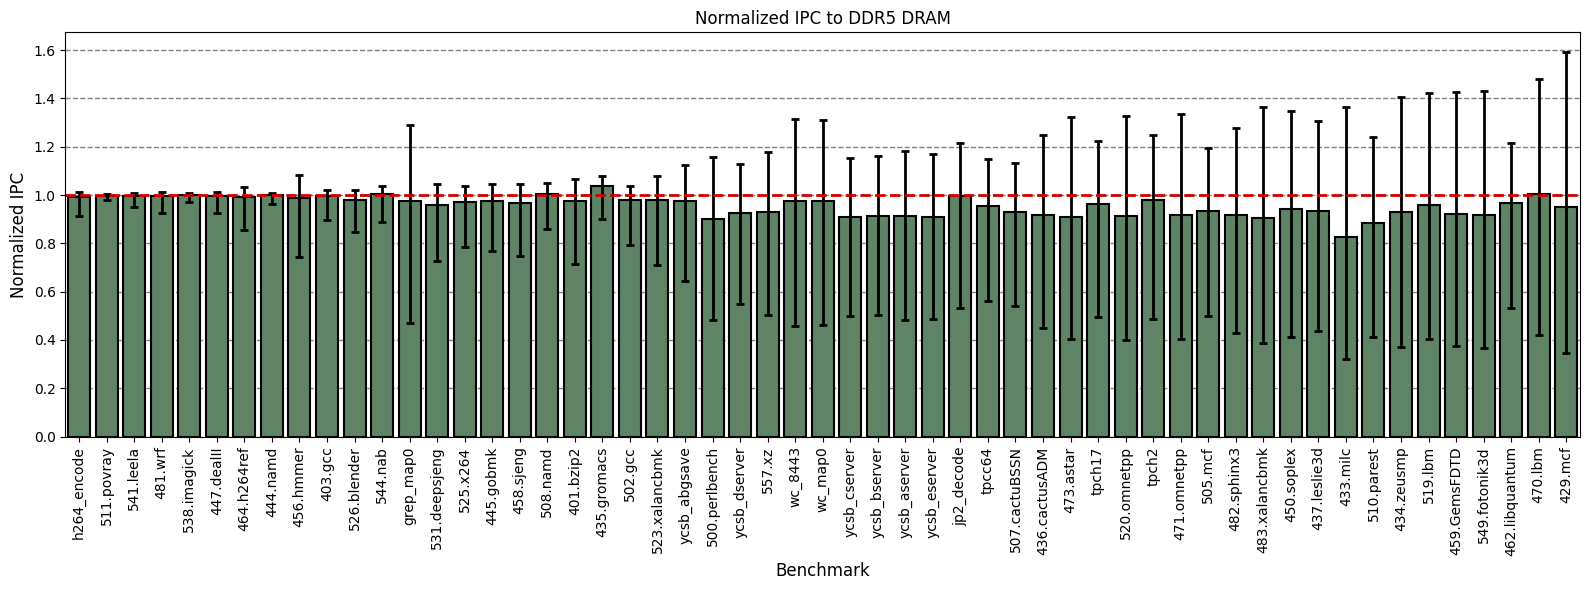

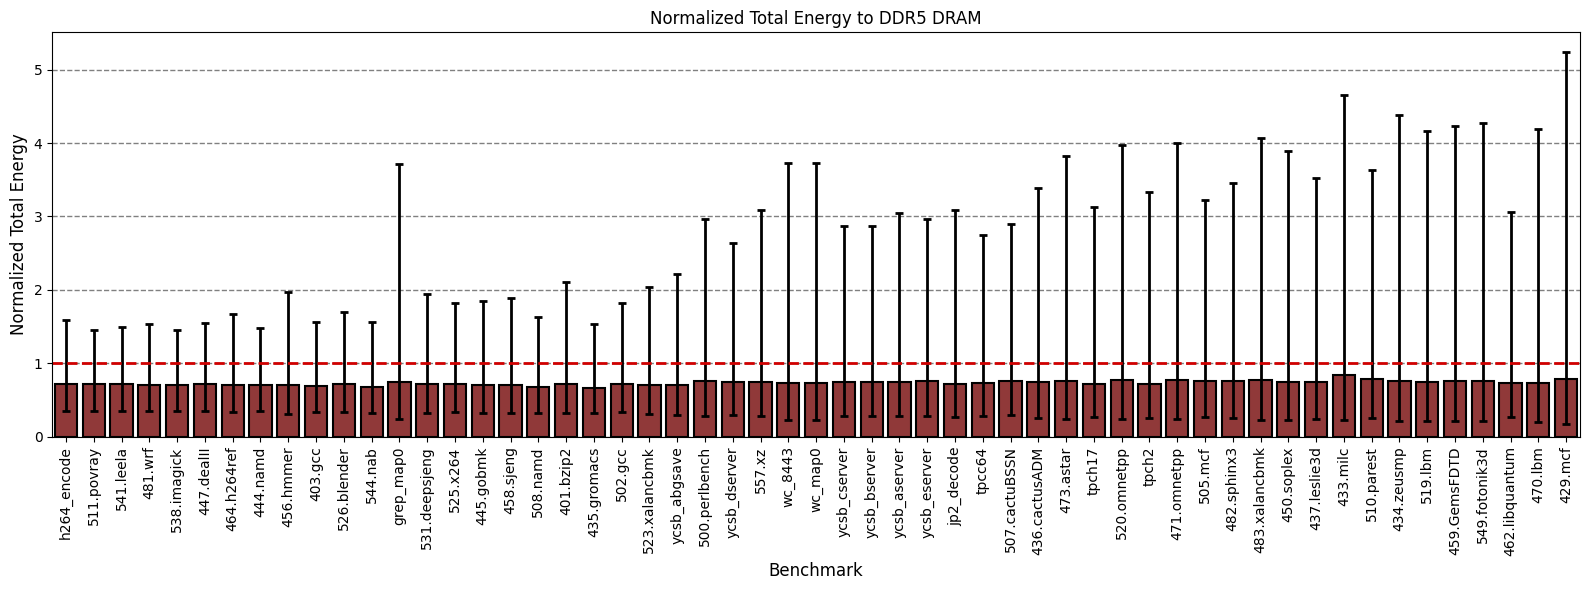

In [43]:
combined_df = pd.merge(sc_uram5_df[['Trace', 'Area Scaling', 'Voltage Scaling', 'IPC', 'Total Energy']],
                       sc_ddr5_df[ ['Trace', 'Area Scaling', 'Voltage Scaling', 'IPC', 'Total Energy']],
                       on='Trace', suffixes=(' URAM5', ' DDR5'))

combined_df['Normalized IPC']          = combined_df['IPC URAM5'] / combined_df['IPC DDR5']
combined_df['Normalized Total Energy'] = combined_df['Total Energy URAM5'] / combined_df['Total Energy DDR5']

combined_df = combined_df[['Trace', 'Area Scaling URAM5', 'Voltage Scaling URAM5', 'Normalized IPC', 'Normalized Total Energy']]
base_df = combined_df[(combined_df['Area Scaling URAM5'] == 1.0) & (combined_df['Voltage Scaling URAM5'] == 1.0)]

#-------------------------------------------------------------------------------

for idx, metric in enumerate(['Normalized IPC', 'Normalized Total Energy']):
  error_df = combined_df.groupby('Trace')[metric].agg(['min', 'mean', 'max']).reset_index()
  error_df = error_df.set_index('Trace').reindex(combined_df['Trace'].drop_duplicates().values).reset_index()

  plt.figure(figsize=(16, 6))

  barplot = sns.barplot(data=base_df, x='Trace', y=metric, edgecolor='black', 
                        linewidth=1.5, color=color_palette[idx], zorder=2)

  bar_positions = barplot.get_xticks()
  for i, row in error_df.iterrows():
    barplot.errorbar(x=bar_positions[i], y=row['mean'], 
                      yerr=[[row['mean'] - row['min']], [row['max'] - row['mean']]], 
                      fmt='none', color='black', capsize=3, capthick=2, elinewidth=2)

  barplot.set_xlabel('Benchmark', fontsize=12)
  barplot.set_ylabel(f'{metric}', fontsize=12)
  barplot.set_title(f'{metric} to DDR5 DRAM', fontsize=12)
  barplot.grid(True, which='major', axis='y', linestyle='--', linewidth=1, color='gray', zorder=0)

  barplot.axhline(y=1.0, color='#d00000', linestyle='--', linewidth=2)
  barplot.set_xlim(-0.5, len(base_df['Trace']) - 0.5)

  plt.xticks(rotation=90)
  plt.tight_layout()
  plt.show()

### Multicore Plots

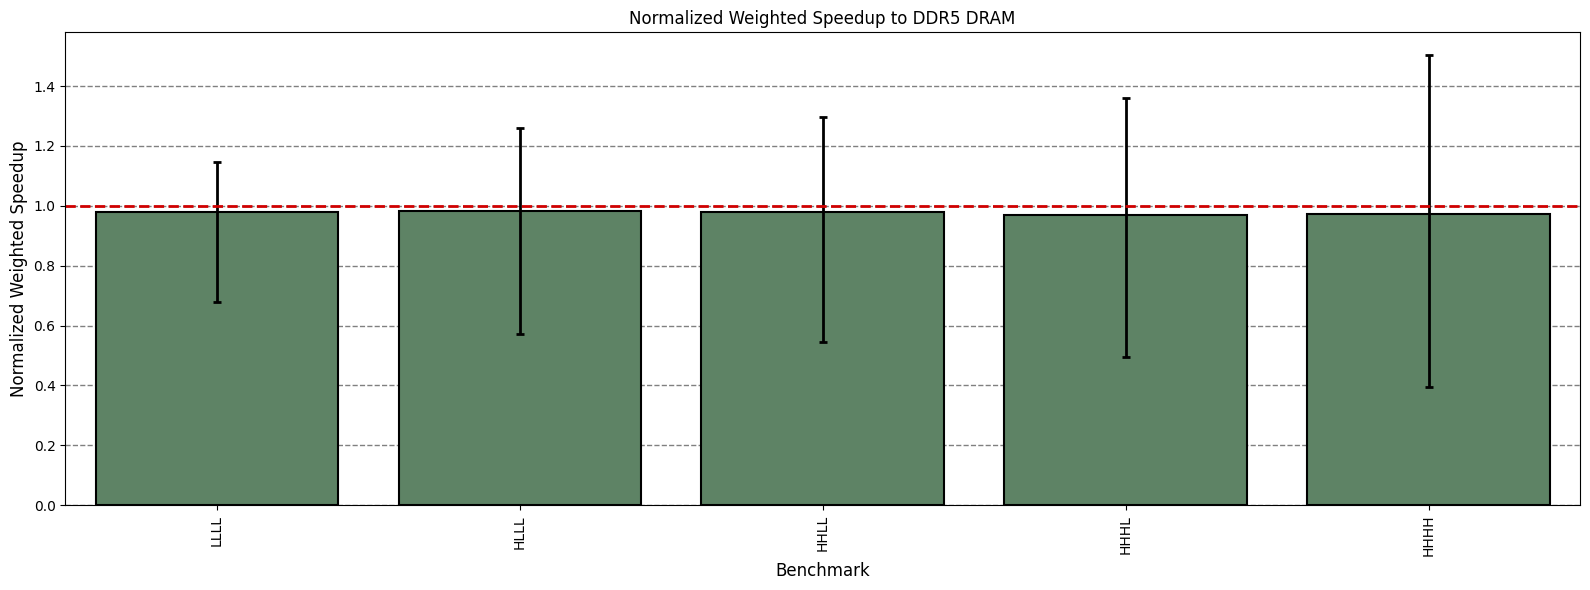

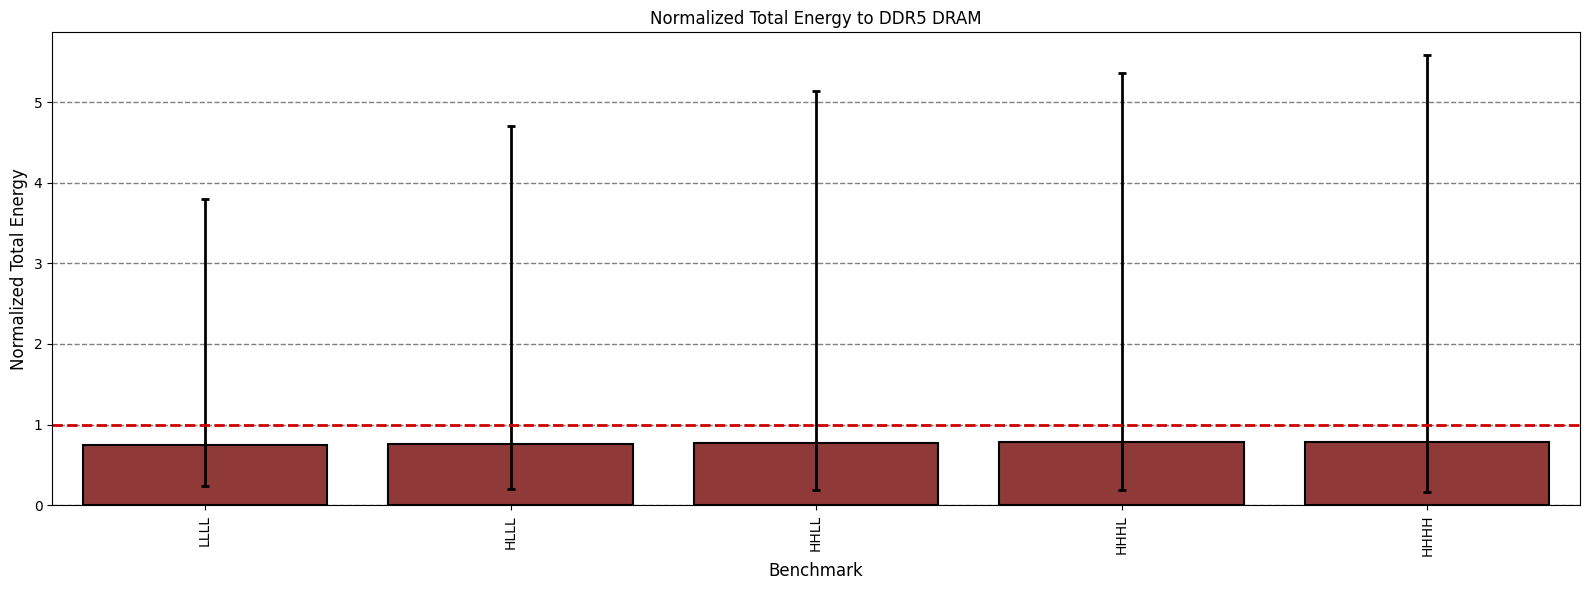

In [ ]:
combined_df = pd.merge(mc_uram5_df[['Trace', 'Area Scaling', 'Voltage Scaling', 'Weighted Speedup', 'Total Energy']],
                       mc_ddr5_df[['Trace', 'Area Scaling', 'Voltage Scaling', 'Weighted Speedup', 'Total Energy']],
                       on='Trace', suffixes=(' URAM5', ' DDR5'))

combined_df['Normalized Weighted Speedup'] = combined_df['Weighted Speedup URAM5'] / combined_df['Weighted Speedup DDR5']
combined_df['Normalized Total Energy']     = combined_df['Total Energy URAM5']     / combined_df['Total Energy DDR5']

combined_df = combined_df[['Trace', 'Area Scaling URAM5', 'Voltage Scaling URAM5', 'Normalized Weighted Speedup', 'Normalized Total Energy']]

group_count = pd.Series(combined_df['Trace'].unique()).str.startswith('HHHH').sum()
for idx, metric in enumerate(['Normalized Weighted Speedup', 'Normalized Total Energy']):
  error_df = combined_df.groupby('Trace')[metric].agg(['min', 'mean', 'max']).reset_index()
  error_df = error_df.set_index('Trace').reindex(combined_df['Trace'].drop_duplicates().values).reset_index()

  base_df = combined_df[(combined_df['Area Scaling URAM5'] == 1.0) &  (combined_df['Voltage Scaling URAM5'] == 1.0)].copy()
  base_df.loc[:, 'Trace Prefix'] = base_df['Trace'].str.extract(r'([A-Za-z]+)', expand=False)
  agg_base_df         = base_df.groupby('Trace Prefix').sum().reset_index()
  agg_base_df[metric] =  agg_base_df[metric] / group_count
  agg_base_df.sort_values(by='Trace Prefix', ascending=False, inplace=True)

  error_df.loc[:, 'Trace Prefix'] = error_df['Trace'].str.extract(r'([A-Za-z]+)', expand=False)
  agg_error_df = error_df.groupby('Trace Prefix').sum().reset_index()
  agg_error_df['max']  = agg_error_df['max']  / group_count
  agg_error_df['mean'] = agg_error_df['mean'] / group_count
  agg_error_df['min']  = agg_error_df['min']  / group_count
  agg_error_df = agg_error_df.set_index('Trace Prefix').reindex(agg_base_df['Trace Prefix'].drop_duplicates().values).reset_index()

  #-----------------------------------------------------------------------------

  plt.figure(figsize=(16, 6))

  barplot = sns.barplot(data=agg_base_df, x='Trace Prefix', y=metric, edgecolor='black', 
                        linewidth=1.5, color=color_palette[idx], zorder=2)

  bar_positions = barplot.get_xticks()
  for i, row in agg_error_df.iterrows():
    barplot.errorbar(x=bar_positions[i], y=row['mean'], 
                      yerr=[[row['mean'] - row['min']], [row['max'] - row['mean']]], 
                      fmt='none', color='black', capsize=3, capthick=2, elinewidth=2)

  barplot.set_xlabel('Benchmark', fontsize=12)
  barplot.set_ylabel(f'{metric}', fontsize=12)
  barplot.set_title(f'{metric} to DDR5 DRAM', fontsize=12)
  barplot.grid(True, which='major', axis='y', linestyle='--', linewidth=1, color='gray', zorder=0)

  barplot.axhline(y=1.0, color='#d00000', linestyle='--', linewidth=2)
  barplot.set_xlim(-0.5, len(agg_base_df['Trace']) - 0.5)

  plt.xticks(rotation=90)
  plt.tight_layout()
  plt.show()


### refresh related

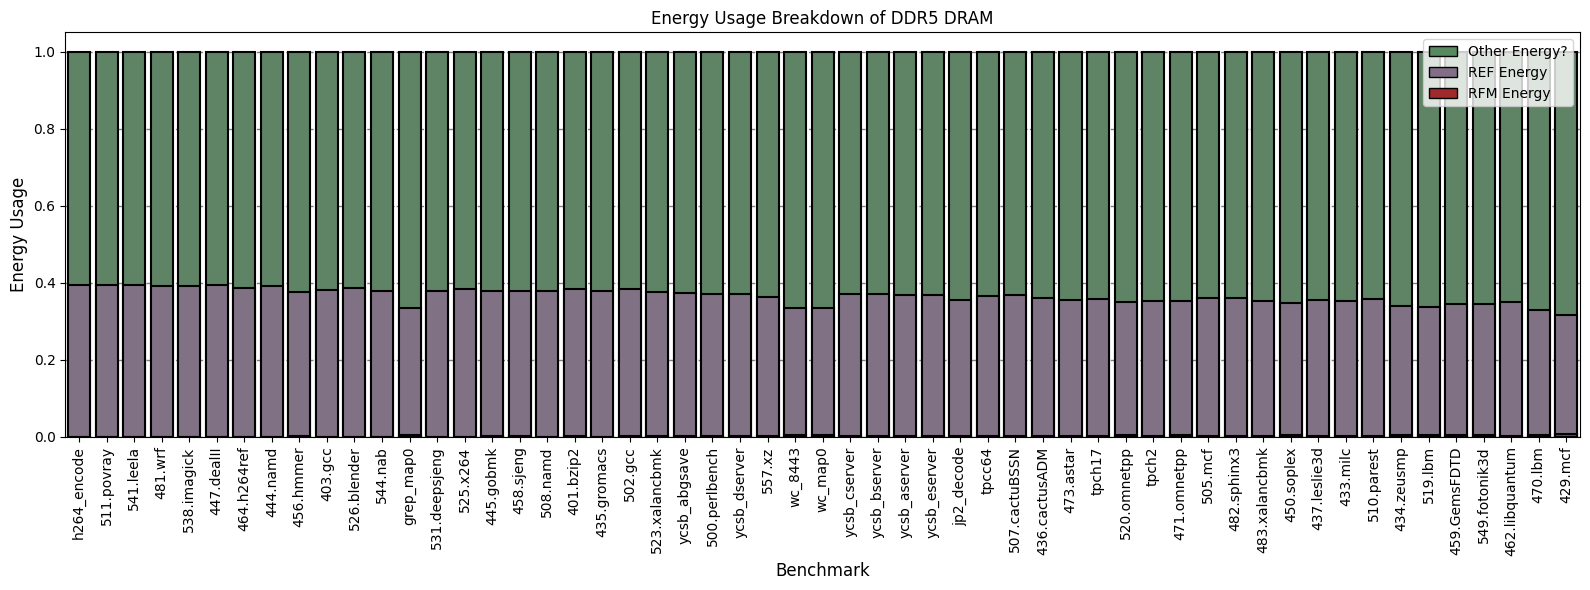

In [45]:
from matplotlib.patches import Patch

energy_df = sc_df[(sc_df['Device'] == 'DDR5' ) & (sc_df['Row Policy'] == 'OpenRowPolicy') & (sc_df['Area Scaling'] == 1.0) & (sc_df['Voltage Scaling'] == 1.0)].copy()
energy_df.loc[:, 'Normalized Total RFM Energy'] = energy_df['Yaml'].apply(lambda x: x['MemorySystem']['DRAM']['total_rfm_energy'] / x['MemorySystem']['DRAM']['total_energy'])
energy_df.loc[:, 'Normalized Total REF Energy'] = energy_df['Yaml'].apply(lambda x: x['MemorySystem']['DRAM']['total_ref_energy'] / x['MemorySystem']['DRAM']['total_energy'])
energy_df.loc[:, 'Normalized Total REF Energy'] = energy_df['Normalized Total REF Energy'] + energy_df['Normalized Total RFM Energy']
energy_df.loc[:, 'Normalized Total Energy']     = 1.0
energy_df = energy_df[['Trace', 'Normalized Total Energy', 'Normalized Total REF Energy', 'Normalized Total RFM Energy']]

#-------------------------------------------------------------------------------

plt.figure(figsize=(16, 6))

barplot = sns.barplot(data=energy_df, x='Trace', y='Normalized Total Energy', edgecolor='black', 
                      linewidth=1.5, color=color_palette[0], zorder=2)
sns.barplot(data=energy_df, x='Trace', y='Normalized Total REF Energy', edgecolor='black', 
            linewidth=1.5, color=color_palette[2], zorder=2)
sns.barplot(data=energy_df, x='Trace', y='Normalized Total RFM Energy', edgecolor='black', 
            linewidth=1.5, color=color_palette[1], zorder=2)

barplot.set_xlabel('Benchmark', fontsize=12)
barplot.set_title('Energy Usage Breakdown of DDR5 DRAM', fontsize=12)
barplot.set_ylabel(f'Energy Usage', fontsize=12)
barplot.grid(True, which='major', axis='y', linestyle='--', linewidth=1, color='gray', zorder=0)

legend_elements = [
  Patch(facecolor=color_palette[0], edgecolor='black', label='Other Energy?'),
  Patch(facecolor=color_palette[2], edgecolor='black', label='REF Energy'),
  Patch(facecolor=color_palette[1], edgecolor='black', label='RFM Energy')
]
barplot.legend(handles=legend_elements, loc='upper right')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

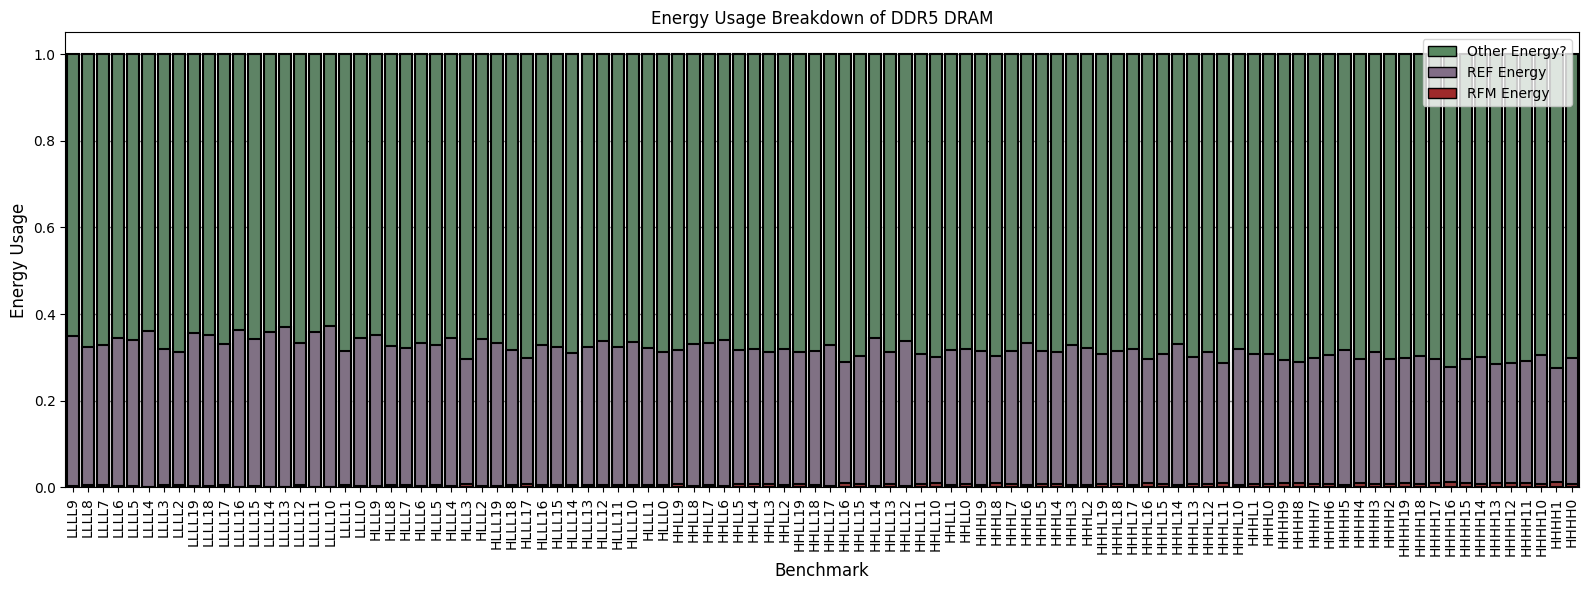

In [46]:

from matplotlib.patches import Patch

ddr5_df = mc_df[(mc_df['Device'] == 'DDR5' ) & (mc_df['Row Policy'] == 'OpenRowPolicy') & (mc_df['Area Scaling'] == 1.0) & (mc_df['Voltage Scaling'] == 1.0)].copy()
ddr5_df.loc[:, 'Normalized Total RFM Energy'] = ddr5_df['Yaml'].apply(lambda x: x['MemorySystem']['DRAM']['total_rfm_energy'] / x['MemorySystem']['DRAM']['total_energy'])
ddr5_df.loc[:, 'Normalized Total REF Energy'] = ddr5_df['Yaml'].apply(lambda x: x['MemorySystem']['DRAM']['total_ref_energy'] / x['MemorySystem']['DRAM']['total_energy'])
ddr5_df.loc[:, 'Normalized Total REF Energy'] = ddr5_df['Normalized Total REF Energy'] + ddr5_df['Normalized Total RFM Energy']
ddr5_df.loc[:, 'Normalized Total Energy']     = 1.0
ddr5_df = ddr5_df[['Trace', 'Normalized Total Energy', 'Normalized Total REF Energy', 'Normalized Total RFM Energy']]

#-------------------------------------------------------------------------------

plt.figure(figsize=(16, 6))

barplot = sns.barplot(data=ddr5_df, x='Trace', y='Normalized Total Energy', edgecolor='black', 
                      linewidth=1.5, color=color_palette[0], zorder=2)
sns.barplot(data=ddr5_df, x='Trace', y='Normalized Total REF Energy', edgecolor='black', 
            linewidth=1.5, color=color_palette[2], zorder=2)
sns.barplot(data=ddr5_df, x='Trace', y='Normalized Total RFM Energy', edgecolor='black', 
            linewidth=1.5, color=color_palette[1], zorder=2)

barplot.set_xlabel('Benchmark', fontsize=12)
barplot.set_title('Energy Usage Breakdown of DDR5 DRAM', fontsize=12)
barplot.set_ylabel(f'Energy Usage', fontsize=12)
barplot.grid(True, which='major', axis='y', linestyle='--', linewidth=1, color='gray', zorder=0)

legend_elements = [
  Patch(facecolor=color_palette[0], edgecolor='black', label='Other Energy?'),
  Patch(facecolor=color_palette[2], edgecolor='black', label='REF Energy'),
  Patch(facecolor=color_palette[1], edgecolor='black', label='RFM Energy')
]
barplot.legend(handles=legend_elements, loc='upper right')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()